In [10]:
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt


In [2]:
dataset = rioxarray.open_rasterio("data/wind/FIN_wind-speed_100m.tif")
dataset

<xarray.DataArray (band: 1, y: 4497, x: 4999)> Size: 90MB
[22480503 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 40kB 19.09 19.09 19.09 19.09 ... 31.58 31.58 31.58
  * y            (y) float64 36kB 70.09 70.08 70.08 70.08 ... 58.85 58.85 58.85
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     nan
    scale_factor:   1.0
    add_offset:     0.0

In [3]:
# Transform raster layer to flat dataframe
# Could be slow with individual unpivots if multiple layers

df = (
    dataset[0]      # Expect all layers to only have one channel
    .to_pandas()
    .reset_index()  # Preserve index (y, lat) during melt
    .melt(          # unpivot 2d raster -> tabular
        id_vars='y',
        var_name='long',
        value_name='wind-speed-100m',
    ).dropna()
    .rename(columns={'y': 'lat'})
)
df.head()

,lat,long,wind-speed-100m
3955,60.199519,19.085323,9.009042
3956,60.197019,19.085323,9.008957
3957,60.194519,19.085323,9.009287
3958,60.192019,19.085323,9.008627
3959,60.189519,19.085323,9.006166


In [4]:
dataset.rio.crs

CRS.from_epsg(4326)

In [5]:
gdf = gpd.GeoDataFrame(
    df['wind-speed-100m'],
    geometry=gpd.points_from_xy(df['long'], df['lat']),
    crs=dataset.rio.crs,
)
gdf.head()

,wind-speed-100m,geometry
3955,9.009042,POINT (19.08532 60.19952)
3956,9.008957,POINT (19.08532 60.19702)
3957,9.009287,POINT (19.08532 60.19452)
3958,9.008627,POINT (19.08532 60.19202)
3959,9.006166,POINT (19.08532 60.18952)


<Axes: >

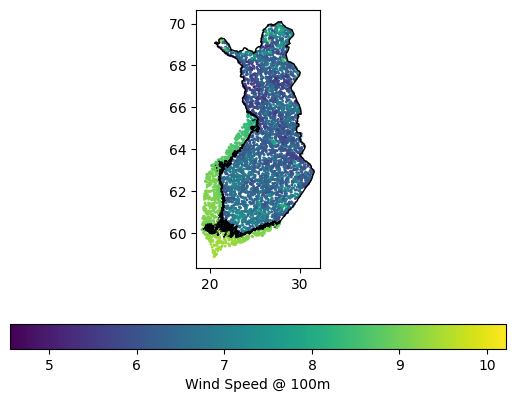

In [6]:
bound = gpd.read_file('data/wind/finland.geojson')
map_ = bound.plot(color='none', edgecolor='black', zorder=2)
gdf.sample(5000).plot(
    ax=map_,
    column='wind-speed-100m',
    markersize=1,
    legend=True, legend_kwds={"label": "Wind Speed @ 100m", "orientation": "horizontal"},
)


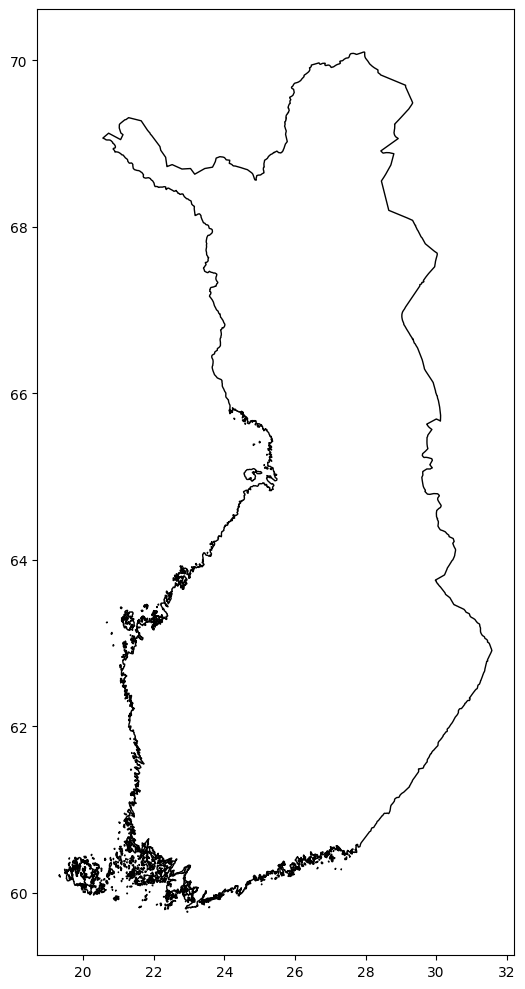

In [27]:
map_ = bound.plot(figsize=(10, 10), color='none', edgecolor='black', linewidth=1, zorder=2)
plt.savefig('imgs/map-of-finland.png', transparent=True)

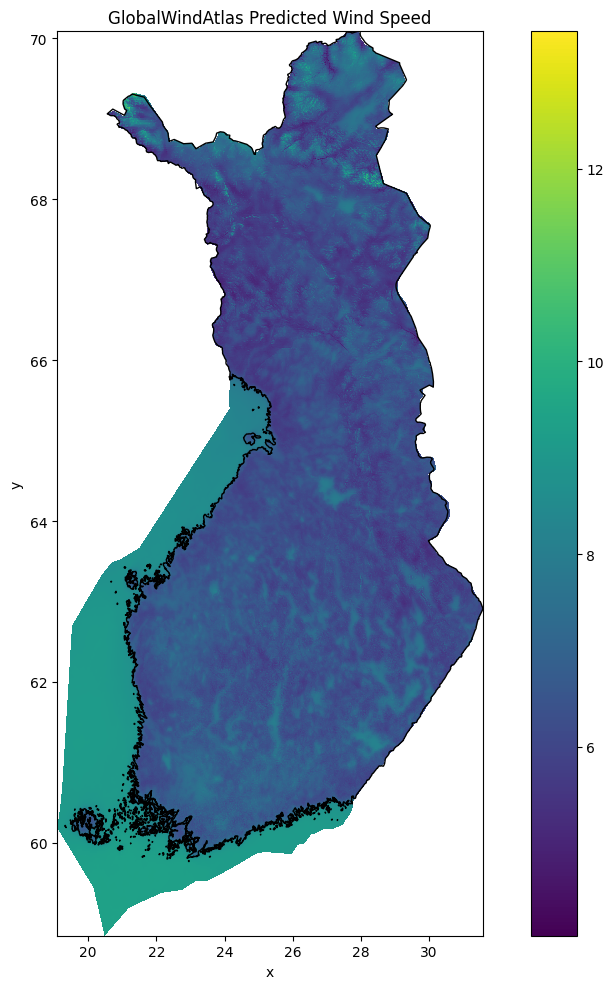

In [24]:
map_ = bound.plot(figsize=(10, 10), color='none', edgecolor='black', linewidth=1, zorder=2)
dataset.plot(ax=map_, cmap='viridis', zorder=1)
map_.set_title("GlobalWindAtlas Predicted Wind Speed")
plt.savefig('imgs/wind-speed.png', transparent=True)

In [7]:
def load_feature(file, name):
    raster = rioxarray.open_rasterio(file)
    df = (
        raster[0]       # Expect all layers to only have one channel
        .to_pandas()
        .reset_index()  # Preserve index (y, lat) during melt
        .melt(          # unpivot 2d raster -> tabular
            id_vars='y',
            var_name='long',
            value_name=name,
        ).dropna()
        .rename(columns={'y': 'lat'})
    )
    return df

# WIND_ATLAS_FIN = 'https://globalwindatlas.info/api/gis/country/FIN'
# uri={WIND_ATLAS_FIN}/wind-speed/100


# Features:
# power-density: should roughly corelate with wind-speed
# air-density: air density at sea level, higher air density -> (generally) lower cooling costs
# capacity-factor: estimated annual energy yield
wind_features = (
    load_feature('data/wind/FIN_wind-speed_100m.tif', 'wind-speed-100m').merge(
        load_feature('data/wind/FIN_power-density_100m.tif', 'power-density-100m'),
        on=['lat', 'long']
    ).merge(
        load_feature('data/wind/FIN_capacity-factor_IEC3.tif', 'capacity-factor'),
        on=['lat', 'long'],
    ).merge(
        load_feature('data/wind/FIN_air-density_10m.tif', 'air-density-sea-level'),
        on=['lat', 'long'],
    ).merge(
        load_feature('data/wind/FIN_elevation_w_bathymetry.tif', 'elevation-variation'),
        on=['lat', 'long'],
    )

)
wind_features.head()

,lat,long,wind-speed-100m,power-density-100m,capacity-factor,air-density-sea-level,elevation-variation
0,60.199519,19.085323,9.009042,763.828064,0.629013,1.253402,-265.0
1,60.197019,19.085323,9.008957,763.531067,0.629075,1.253402,-261.0
2,60.194519,19.085323,9.009287,763.516479,0.629133,1.253402,-261.0
3,60.192019,19.085323,9.008627,763.479004,0.629069,1.253402,-254.0
4,60.189519,19.085323,9.006166,762.496643,0.629036,1.253402,-245.0


<Axes: xlabel='wind-speed-100m', ylabel='power-density-100m'>

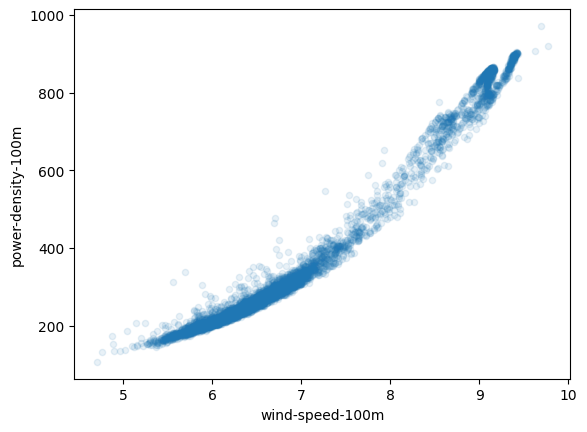

In [8]:
wind_features.sample(5000).plot.scatter(x='wind-speed-100m', y='power-density-100m', alpha=0.1)

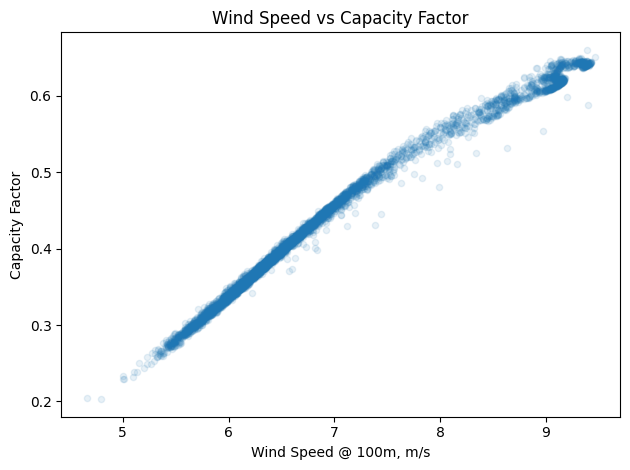

In [25]:
wind_features.sample(5000).plot.scatter(x='wind-speed-100m', y='capacity-factor', alpha=0.1)
plt.title("Wind Speed vs Capacity Factor")
plt.ylabel("Capacity Factor")
plt.xlabel("Wind Speed @ 100m, m/s")
plt.savefig('imgs/wind-speed-vs-capacity-factor.png', transparent=True)

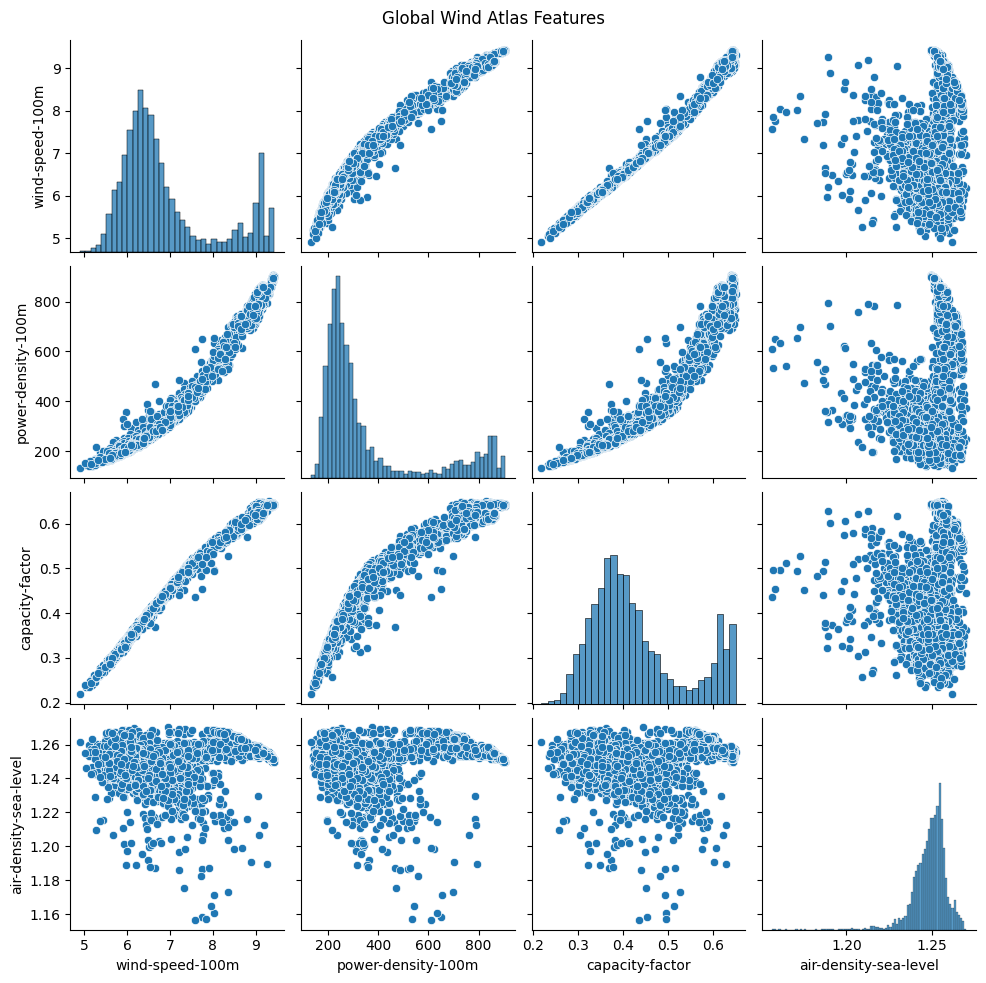

In [21]:
import seaborn as sns

pp = sns.pairplot(data=wind_features.sample(5000)[["wind-speed-100m","power-density-100m","capacity-factor","air-density-sea-level"]])
pp.figure.suptitle("Global Wind Atlas Features")
plt.subplots_adjust(top=0.95)
plt.savefig('imgs/wind-features-pairplot.png')